In [4]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Lattice2D, BrickwallLatticeGeometry, SimulationParameters

In [11]:
omega = 2 * np.pi / 4

geometry = BrickwallLatticeGeometry((7, 14))

# Convergence Testing

Test RK4 solver with different step sizes; compare sparse and non-sparse hamiltonian.

In [ ]:
import time

# Define step sizes to test (from smallest to largest)
h_values = [1e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]

# Function to run simulation and return results and timing
def run_simulation(h, use_sparse=True):
    start_time = time.time()
    
    params_h = SimulationParameters(
        t_hop=1.0,
        E_amplitude=lambda t: np.sin(omega * t),
        E_direction=np.array([0, -1]),
        h=h,
        T=10,
        charge=1,
        initial_occupation=0.5,
    )
    
    lattice = Lattice2D(geometry, params_h)
    lattice.evolve(solver="rk4", use_sparse=use_sparse, sample_every=0)
    final_state = lattice.states[-1].density.diagonal().real
    
    elapsed_time = time.time() - start_time
    return final_state, elapsed_time

In [16]:
results_sparse = []
times_sparse = []
results_dense = []
times_dense = []

for h in h_values:
    print(f"Running with h={h}")
    
    # print("  - Sparse matrix...")
    final_state, elapsed = run_simulation(h, use_sparse=True)
    results_sparse.append(final_state)
    times_sparse.append(elapsed)
    print(f"Completed in {elapsed:.2f} seconds")
    
    # print("  - Dense matrix...")
    # final_state, elapsed = run_simulation(h, use_sparse=False)
    # results_dense.append(final_state)
    # times_dense.append(elapsed)
    # print(f"    Completed in {elapsed:.2f} seconds")

Running with h=1e-05
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 999999/999999 [10:09<00:00, 1640.09it/s]


Completed in 609.73 seconds
Running with h=0.0005
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 20000/20000 [00:12<00:00, 1628.82it/s]


Completed in 12.28 seconds
Running with h=0.0001
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 100000/100000 [01:00<00:00, 1662.25it/s]


Completed in 60.16 seconds
Running with h=0.0002
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 50000/50000 [00:30<00:00, 1636.27it/s]


Completed in 30.56 seconds
Running with h=0.0005
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 20000/20000 [00:12<00:00, 1628.13it/s]


Completed in 12.29 seconds
Running with h=0.001
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 10000/10000 [00:06<00:00, 1620.41it/s]


Completed in 6.17 seconds
Running with h=0.002
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 5000/5000 [00:03<00:00, 1640.90it/s]


Completed in 3.05 seconds
Running with h=0.005
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 2000/2000 [00:01<00:00, 1557.44it/s]


Completed in 1.29 seconds
Running with h=0.01
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 1000/1000 [00:00<00:00, 1589.67it/s]


Completed in 0.63 seconds
Running with h=0.02
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 500/500 [00:00<00:00, 1575.98it/s]


Completed in 0.32 seconds
Running with h=0.05
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 200/200 [00:00<00:00, 1593.14it/s]


Completed in 0.13 seconds
Running with h=0.1
Initialize Hamiltonian and eigenstates... Done.
Occupation set to 0.50.


100%|██████████| 100/100 [00:00<00:00, 1584.56it/s]

Completed in 0.07 seconds


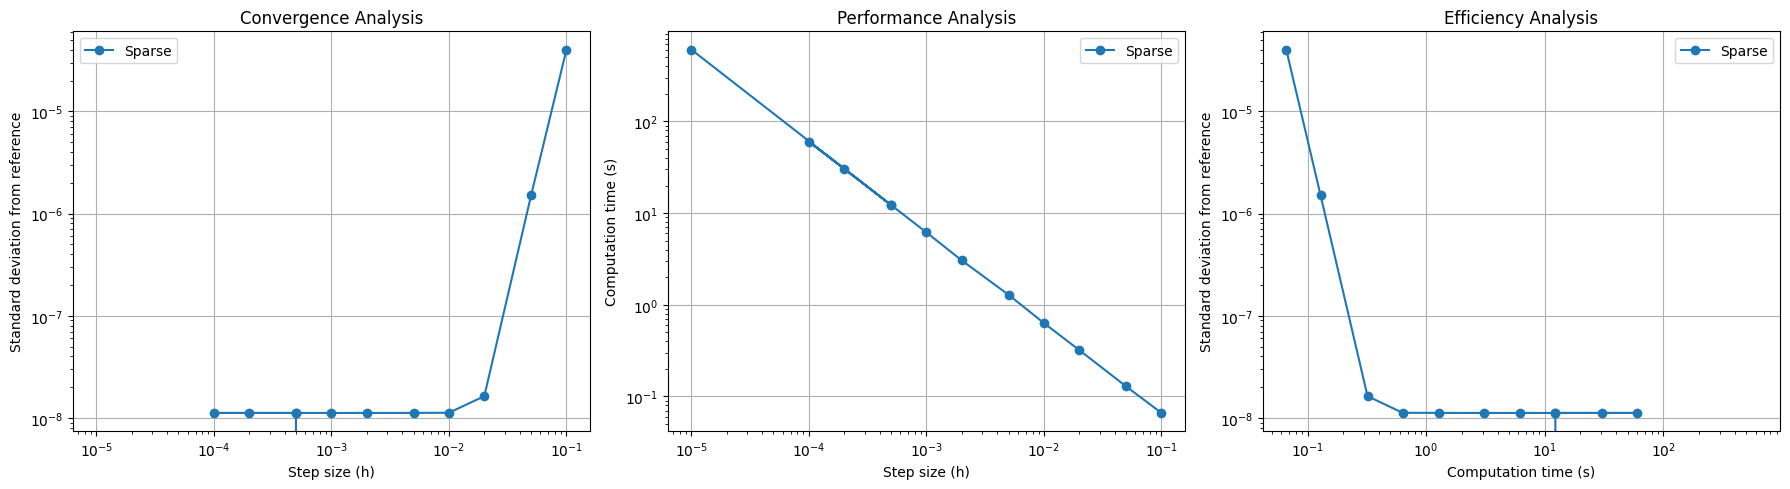

In [27]:
# Calculate standard deviations from the reference solution (smallest h)
reference_sparse = results_sparse[0]
# reference_dense = results_dense[0]

deviations_sparse = [np.std(result - reference_sparse) for result in results_sparse]
# deviations_dense = [np.std(result - reference_dense) for result in results_dense]

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot standard deviations vs h
ax1.loglog(h_values, deviations_sparse, 'o-', label='Sparse')
# ax1.set_xscale('log')
# ax1.loglog(h_values, deviations_dense, 's-', label='Dense')
ax1.set_xlabel('Step size (h)')
ax1.set_ylabel('Standard deviation from reference')
ax1.set_title('Convergence Analysis')
ax1.legend()
ax1.grid(True)

# Plot computation time vs h
ax2.loglog(h_values, times_sparse, 'o-', label='Sparse')
# ax2.loglog(h_values, times_dense, 's-', label='Dense')
ax2.set_xlabel('Step size (h)')
ax2.set_ylabel('Computation time (s)')
ax2.set_title('Performance Analysis')
ax2.legend()
ax2.grid(True)

# Plot efficiency: deviation vs time
ax3.loglog(times_sparse, deviations_sparse, 'o-', label='Sparse')
# ax3.loglog(times_dense, deviations_dense, 's-', label='Dense')
ax3.set_xlabel('Computation time (s)')
ax3.set_ylabel('Standard deviation from reference')
ax3.set_title('Efficiency Analysis')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

## Analysis and Optimal Step Size

We can determine an optimal step size by finding where the deviation starts to grow significantly. This represents the best balance between accuracy and performance.

In [ ]:
# Find optimal h based on deviation threshold
threshold = 1e-7

print("Sparse Matrix Results:")
print("-" * 60)
print(f"{'Step size (h)':<15} {'Deviation':<15} {'Time (s)':<15} {'Optimal?':<15}")
print("-" * 60)

for h, dev, t in zip(h_values, deviations_sparse, times_sparse):
    optimal = "Yes" if dev < threshold else "No"
    print(f"{h:<15.6f} {dev:<15.6e} {t:<15.3f} {optimal:<15}")

# print("\nDense Matrix Results:")
# print("-" * 60)
# print(f"{'Step size (h)':<15} {'Deviation':<15} {'Time (s)':<15} {'Optimal?':<15}")
# print("-" * 60)

# for h, dev, t in zip(h_values, deviations_dense, times_dense):
#     optimal = "Yes" if dev < threshold else "No"
#     print(f"{h:<15.6f} {dev:<15.6e} {t:<15.3f} {optimal:<15}")

Sparse Matrix Results:
------------------------------------------------------------
Step size (h)   Deviation       Time (s)        Optimal?       
------------------------------------------------------------
0.000010        0.000000e+00    609.727         Yes            
0.000500        1.119792e-08    12.282          Yes            
0.000100        1.119792e-08    60.163          Yes            
0.000200        1.119792e-08    30.560          Yes            
0.000500        1.119792e-08    12.287          Yes            
0.001000        1.119795e-08    6.174           Yes            
0.002000        1.119830e-08    3.050           Yes            
0.005000        1.120798e-08    1.287           Yes            
0.010000        1.124422e-08    0.632           Yes            
0.020000        1.634752e-08    0.321           Yes            
0.050000        1.506383e-06    0.129           No             
0.100000        4.028880e-05    0.066           No             
